# Imports

In [59]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, recall_score, precision_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

data_dir = "data/" # Define data path

# Read Data

In [60]:
df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
#print(len(df['district'].unique()))
#print(df['district'].unique())
df.set_index(["date", "district"], inplace=True) # Set index



# Read Sentiment of Articles

In [61]:
news_df = pd.read_csv(data_dir + "topic_sentiment.csv") # Read news data into DataFrame

# Create date column
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["date"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

news_df.drop(['tokens', 'yyyy-mm'], axis=1, inplace=True)
news_features = create_news_features(news_df.columns[5:])
news_features


,hunger,conflict,humanitarian,refugees,politics,economics,production,land,pests,environment,major,topic,sentiment,difference
date,,,,,,,,,,,,,,
2011-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,0.022222,0.0,0.050000,0.000000,4.625929e-18,0.000000,0.055556,4.625929e-18,1.850372e-17,1.850372e-17,0.055556,12.183761,0.283412,0.283412
2023-01-01,0.022222,0.0,0.050000,0.000000,5.555556e-02,0.000000,0.055556,4.625929e-18,1.850372e-17,5.555556e-02,0.055556,13.305556,-0.021430,-0.021430
2023-02-01,0.083333,0.0,0.069444,0.000000,5.555556e-02,0.083333,0.138889,8.333333e-02,1.250000e-01,1.388889e-01,0.097222,13.069444,-0.048976,-0.048976


# Create Lag Function

In [62]:
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    '''
    Function to add lagged colums to dataframe
    
    Inputs:
        df - Dataframe
        columns - List of columns to create lags from
        lag - The number of timesteps (in months for the default data) to lag the variable by
        difference - Whether to take the difference between each observation as new column
        rolling - The size of the rolling mean window, input None type to not use a rolling variable
        dropna - Whether to drop NaN values
        
    Output:
        df - Dataframe with the lagged columns added
    '''
    
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df

def plot_ConfusionMatrix(prediction, true, binary=False):
    brown_palette = sns.dark_palette("brown", as_cmap=True)
    '''
    Function to plot a confusion matrix as a heatmap from a prediction and true values.
    
    Inputs:
        prediction - The predicted values
        true - the true values
        binary - whether the variable is binary or not
        
    Output:
        confusion_matrix - The calculated confusion matrix based on the prediction and true values.
        
        Also plots the confusion matrix as heatmap in an interactive environment such as Jupyter Notebook.
    '''
    
    y_pred = prediction
    
    if not binary:
        # Round prediction to nearest integer (i.e. the nearest phase)
        y_pred = y_pred.round() 
        y_pred = np.minimum(y_pred, 5) # Cap maximum prediction at 5 (maximum phase)
        y_pred = np.maximum(y_pred, 1) # Cap minimum prediction at 1 (minimum phase)

    # Initialize confusion matrix
    confusion_matrix = pd.crosstab(
        true, y_pred, rownames=["Actual"], colnames=["Predicted"]
    )

    # Plot confusion matrix as heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap=brown_palette)
    plt.show()
    plt.clf()
    
    return confusion_matrix

### Create Lag

In [63]:
df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

In [64]:
X = df.iloc[:, -24:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data


# Share of categories

In [65]:
combined = (
    pd.DataFrame(y['ipc'])
    .join(news_df.groupby(["date"])["hunger"].mean())
    .join(news_df.groupby(["date"])["conflict"].mean())
    .join(news_df.groupby(["date"])["refugees"].mean())
    .join(news_df.groupby(["date"])["humanitarian"].mean())
    .join(news_df.groupby(["date"])["politics"].mean())
    .join(news_df.groupby(["date"])["economics"].mean())
    .join(news_df.groupby(["date"])["production"].mean())
    .join(news_df.groupby(["date"])["land"].mean())
    .join(news_df.groupby(["date"])["pests"].mean())
    .join(news_df.groupby(["date"])["environment"].mean())
    .join(news_df.groupby(["date"])["major"].mean())
    .join(news_df.groupby(["date"])["difference"].mean())
)


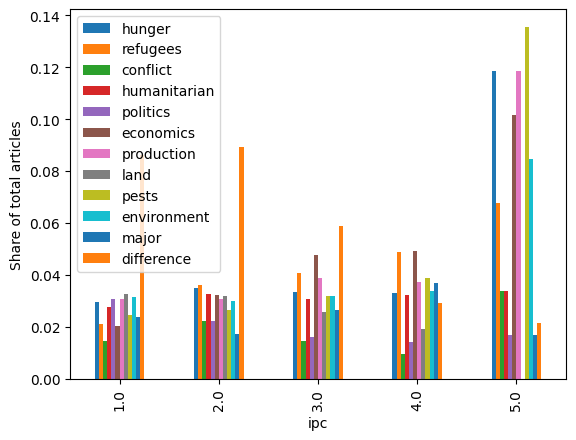

In [66]:
combined.groupby("ipc")[["hunger", "refugees", "conflict", "humanitarian", 
                         "politics", "economics", "production", "land", "pests", 
                         "environment", "major", "difference"]].mean().plot(
    kind="bar", ylabel="Share of total articles"
);

In [67]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.join(news_features, how="left") # Join df with created news features

# Custom Evaluate Function

In [68]:
def evaluate(y_pred, y_true, results, train_index, val_index):
    '''
    Function to evaluate the performance of a model by calculating the accuracy score and plotting the confusion matrix.
    
    Inputs:
        predy - The predicted values
        y - The true values
        results - fitted model results
        
    Output:
        accuracy - The accuracy score of the model
        confusion_matrix - The confusion matrix of the model
    '''
    y_pred_rounded = y_pred.round() 
    y_pred_rounded = np.minimum(y_pred, 5) # Cap maximum prediction at 5 (maximum phase)
    y_pred_rounded = np.maximum(y_pred, 1) # Cap minimum prediction at 1 (minimum phase)
    
    precision_by_class = {i+1: [] for i in range(5)} 
    recall_by_class = {i+1: [] for i in range(5)}

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy score: {accuracy}")
    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_true['ipc']) # Plot confusion matrix, (from helper functions)

    precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred, average=None, labels=range(1, 6), zero_division=0)
    for i in range(5):
        precision_by_class[i+1].append(precision[i])
        recall_by_class[i+1].append(recall[i])

    print(results.summary())

    # Make a list of all the values from y
    y_list = [int(l) for l in list(y.values.flatten())]
    predy_list = [int(l) for l in list(y_pred.values.flatten())]
    
    # roc_auc = roc_auc_score(y_list, predy_list, multi_class='ovr')

    return accuracy, results.rsquared, precision_by_class, recall_by_class, fscore, support

# Preprocess function

In [69]:
def preprocess(y_pred,y_true):

    # Round prediction to nearest integer (i.e. the nearest phase)
    pred = y_pred.round() 
    pred = np.minimum(pred, 5) # Cap maximum prediction at 5 (maximum phase)
    pred = np.maximum(pred, 1) # Cap minimum prediction at 1 (minimum phase)

    true = y_true.dropna() # drop NaN values
    pred = pred.dropna()

    return true, pred

# Pre Log Transformation Histogram

Text(0.5, 1.0, 'Histogram of Food Crisis Before Log Transformation')

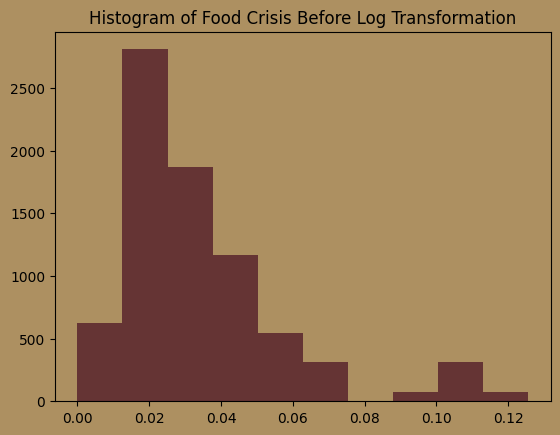

In [70]:
plt.rcParams['axes.facecolor'] = '#AD9061'
plt.rcParams['figure.facecolor'] = '#AD9061'

plt.hist(df['hunger'], color='#653434')
plt.title('Histogram of Food Crisis Before Log Transformation')

# MAIN OLS MODEL + COEFFICIENT CORRELATION

C:\Users\20211445\AppData\Local\Temp\ipykernel_20008\3987265650.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['hunger'] = np.log(X['hunger']+0.001)
C:\Users\20211445\AppData\Local\Temp\ipykernel_20008\3987265650.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['refugees'] = np.log(X['refugees']+0.001)
C:\Users\20211445\AppData\Local\Temp\ipykernel_20008\3987265650.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

const: 413.42530545403963
hunger: 1.9876997428533703
refugees: 1.64159252756003
conflict: 1.561541375607094
politics: 1.9025021417937211
production: 2.4419399772501182
land: 1.8304502679142043
pests: 1.4662484439183592
environment: 1.8358505339808568
count_violence_lag_3: 1.1822115883666933
ndvi_anom_lag_3: 1.1536897913586983
food_price_idx_lag_3: 2.285987418204562
ipc_lag_1: 2.8233746423910278
ipc_lag_2: 3.2020043400650664
ipc_lag_3: 2.3670303939217776
[413.42530545403963, 1.9876997428533703, 1.64159252756003, 1.561541375607094, 1.9025021417937211, 2.4419399772501182, 1.8304502679142043, 1.4662484439183592, 1.8358505339808568, 1.1822115883666933, 1.1536897913586983, 2.285987418204562, 2.8233746423910278, 3.2020043400650664, 2.3670303939217776]


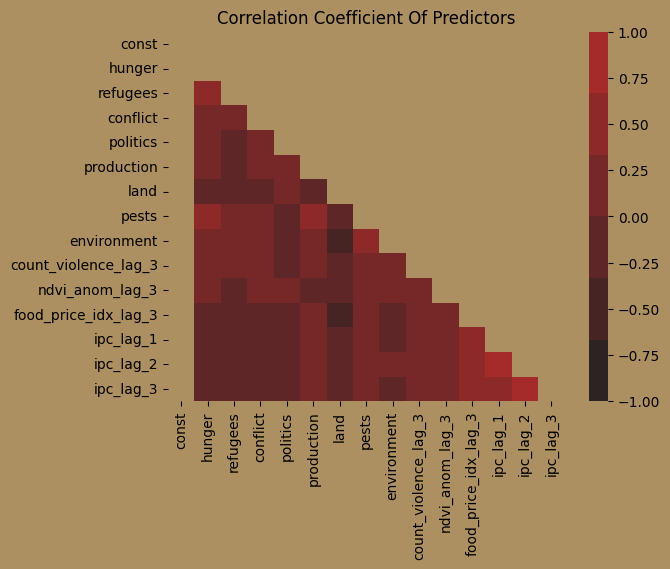

In [71]:
brown_palette = sns.dark_palette("brown")

X = df[['hunger', 'refugees',
       'conflict', 'politics',
       'production', 'land', 'pests',
       'environment','count_violence_lag_3', 'ndvi_anom_lag_3',
       'food_price_idx_lag_3', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3']]

X['hunger'] = np.log(X['hunger']+0.001)
X['refugees'] = np.log(X['refugees']+0.001)
X['land'] = np.sqrt(X['land'])
X['count_violence_lag_3'] = np.log(X['count_violence_lag_3']+0.001)
X['food_price_idx_lag_3'] = np.log(X['food_price_idx_lag_3']+2.001)


X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()
acc_values = list()

# Initialize empty Series for aggregated confusion matrix
predictions = pd.Series(dtype='float64')
all_true_ipc = pd.Series(dtype='float64')

# Initialize a dictionary for all classes
precision_by_class = {i+1: [] for i in range(5)} 
recall_by_class = {i+1: [] for i in range(5)}
support_by_class = {i+1: [] for i in range(5)} 
fscore_by_class = {i+1: [] for i in range(5)}


Xcopy = X.copy()
Xcopy.dropna(inplace=True)
vif = [variance_inflation_factor(Xcopy.values, i) for i in range(len(Xcopy.columns))]
for i in range(len(Xcopy.columns)):
    print(f"{Xcopy.columns[i]}: {vif[i]}")
print(vif)

mask = np.triu(np.ones_like(X.corr(), dtype=bool))

sns.heatmap(X.corr(), annot=False, mask=mask, vmin=-1, vmax=1, cmap=brown_palette)
plt.title('Correlation Coefficient Of Predictors')
plt.show()


# MAIN OLS RESULTS

Accuracy score: 0.6153846153846154
Recall score: 0.5782351586860663
Precision score: 0.6151744231829278
Accuracy score: 0.46853146853146854
Recall score: 0.5230995872055281
Precision score: 0.4239583333333334
Accuracy score: 0.6346153846153846
Recall score: 0.5619411642345109
Precision score: 0.594504717159177
Accuracy score: 0.3717948717948718
Recall score: 0.43586128501382737
Precision score: 0.2964218035979299
Accuracy score: 0.5598290598290598
Recall score: 0.30916894406604906
Precision score: 0.3262028590604364

Mean values:
Mean MAE: 0.58
Mean R2: 0.67
Mean Accuracy: 0.53
Mean Precision by class: {1: 0.3860877684407097, 2: 0.5414558418602977, 3: 0.5556467719167173, 4: 0.25280564503758246, 5: 0.005263157894736842}
Mean Recall by class: {1: 0.40379333844450127, 2: 0.42884878430163553, 3: 0.481251191745159, 4: 0.3842768221390419, 5: 0.2}
Mean Support by class: {1: 111.8, 2: 175.0, 3: 171.0, 4: 36.0, 5: 0.2}
Mean F-score by class: {1: 0.38564449426532155, 2: 0.44977755035607786, 3: 0

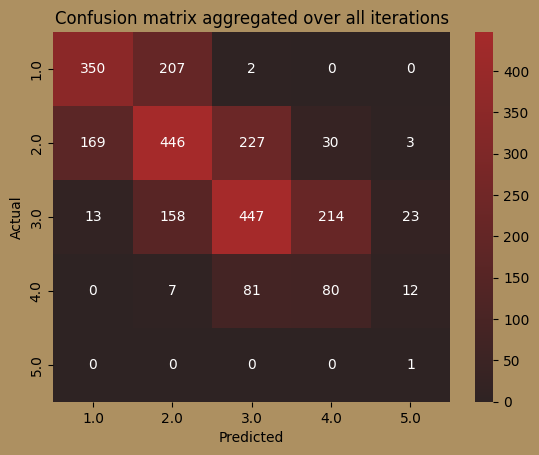

Predicted,1.0,2.0,3.0,4.0,5.0
Actual,,,,,
1.0,350,207,2,0,0
2.0,169,446,227,30,3
3.0,13,158,447,214,23
4.0,0,7,81,80,12
5.0,0,0,0,0,1


<Figure size 640x480 with 0 Axes>

In [72]:
for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data
    y_pred = results.predict(X_test) # Run model on test data

    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    # plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix, (from helper functions)
    true, pred = preprocess(y_pred,y_val['ipc']) # Preprocess predictions for precision

    predictions = pd.concat([predictions, y_pred]) # Concatenate predictions over iterations for final confusion matrix
    all_true_ipc = pd.concat([all_true_ipc, y_val['ipc']])

    accuracy = accuracy_score(true, pred)
    acc_values.append(accuracy)
    print(f"Accuracy score: {accuracy}")
    print("Recall score:", recall_score(true, pred, average="macro", zero_division=0)) # takes true and pred variables as parameters returned by preprocess() function
    print("Precision score:", precision_score(true, pred, average="macro", zero_division=0))
    
    # Calculate precision and recall for each class
    precision, recall, fscore, support = precision_recall_fscore_support(true, pred, average=None, labels=range(1, 6), zero_division=0)

    for i in range(5):
        precision_by_class[i+1].append(precision[i])
        recall_by_class[i+1].append(recall[i])
        support_by_class[i+1].append(support[i])
        fscore_by_class[i+1].append(fscore[i])

# Calculate the mean precision and recall across all iterations for each class
# Do not include entries that had 0 values
list(filter(lambda num: num != 0, precision_by_class))
list(filter(lambda num: num != 0, recall_by_class))
mean_precision_by_class = {i+1: np.mean(precision_by_class[i+1]) for i in range(5)}
mean_recall_by_class = {i+1: np.mean(recall_by_class[i+1]) for i in range(5)}
mean_support_by_class = {i+1: np.mean(support_by_class[i+1]) for i in range(5)}
mean_fscore_by_class = {i+1: np.mean(fscore_by_class[i+1]) for i in range(5)}

# Print mean values of performance metrics
print('\nMean values:')
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2
print(f"Mean Accuracy: {np.mean(acc_values):.2f}") # Print Accuracy
print("Mean Precision by class:", mean_precision_by_class) # Print mean precision by class
print("Mean Recall by class:", mean_recall_by_class) # Print mean recall by class
print("Mean Support by class:", mean_support_by_class) # Print mean support by class
print("Mean F-score by class:", mean_fscore_by_class) # Print mean f-score by class

plt.title('Confusion matrix aggregated over all iterations')
plot_ConfusionMatrix(prediction = predictions, true = all_true_ipc) # Print confusion matrix aggregated from results of all iterations

# Post Transformation Log Histogram

Text(0.5, 1.0, 'Histogram of Food Crisis After Log Transformation')

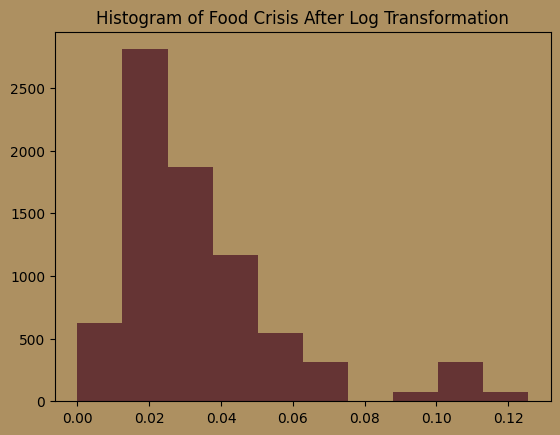

In [79]:
plt.rcParams['axes.facecolor'] = '#AD9061'
plt.rcParams['figure.facecolor'] = '#AD9061'

plt.hist(X['hunger'], color='#653434')
plt.title('Histogram of Food Crisis After Log Transformation')

# Table of Coefficients

In [74]:
results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-0.4812,0.142,-3.394,0.001,-0.759,-0.203
hunger,-0.0279,0.015,-1.893,0.058,-0.057,0.001
refugees,0.0059,0.012,0.494,0.621,-0.018,0.030
conflict,-1.4368,0.532,-2.700,0.007,-2.480,-0.394
politics,-0.8362,0.414,-2.018,0.044,-1.649,-0.024
production,4.9906,0.675,7.390,0.000,3.667,6.314
land,-0.8747,0.104,-8.425,0.000,-1.078,-0.671
pests,-7.1195,0.520,-13.693,0.000,-8.139,-6.100
environment,2.7130,0.471,5.755,0.000,1.789,3.637
count_violence_lag_3,0.0217,0.002,11.328,0.000,0.018,0.025


In [75]:
results = pd.DataFrame({'Accuracy': round(np.mean(acc_values),2), 'MAE': round(np.mean(mae_values),2), 'R2': round(np.mean(r2_values),2)}, index=[0])
results

,Accuracy,MAE,R2
0,0.53,0.58,0.67


# Crisis / No Crisis prediction

Optimization terminated successfully.
         Current function value: 0.023951
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                  962
Model:                          Logit   Df Residuals:                      958
Method:                           MLE   Df Model:                            3
Date:                Fri, 10 Nov 2023   Pseudo R-squ.:                  0.7213
Time:                        16:36:12   Log-Likelihood:                -23.041
converged:                       True   LL-Null:                       -82.676
Covariance Type:            nonrobust   LLR p-value:                 1.108e-25
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.9214      2.560     -6.610      0.000     -21.939     -11.904
ipc_lag_1      7.5452      1

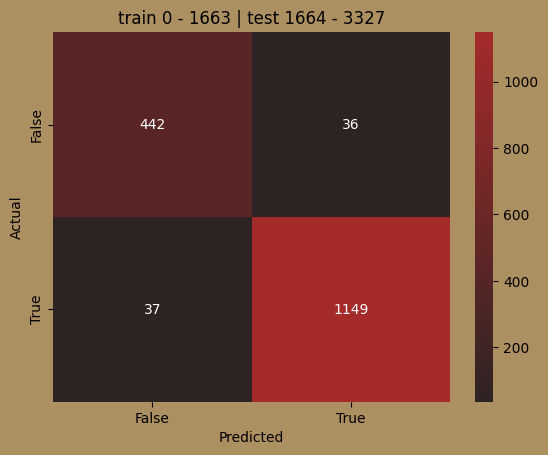

Optimization terminated successfully.
         Current function value: 0.196510
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 2626
Model:                          Logit   Df Residuals:                     2622
Method:                           MLE   Df Model:                            3
Date:                Fri, 10 Nov 2023   Pseudo R-squ.:                  0.4129
Time:                        16:36:13   Log-Likelihood:                -516.04
converged:                       True   LL-Null:                       -878.95
Covariance Type:            nonrobust   LLR p-value:                5.241e-157
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.0771      0.344    -23.471      0.000      -8.752      -7.403
ipc_lag_1      3.0044      0.

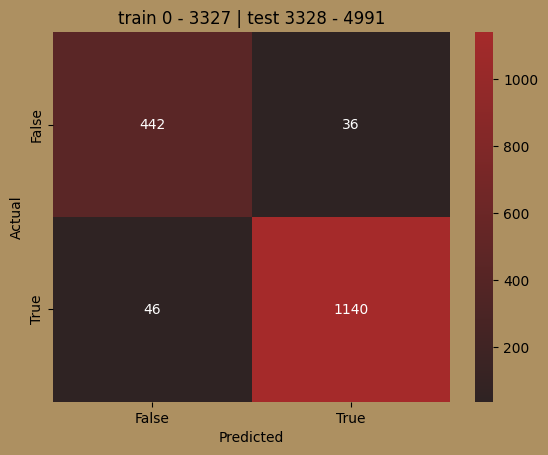

Optimization terminated successfully.
         Current function value: 0.220939
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 4290
Model:                          Logit   Df Residuals:                     4286
Method:                           MLE   Df Model:                            3
Date:                Fri, 10 Nov 2023   Pseudo R-squ.:                  0.3941
Time:                        16:36:13   Log-Likelihood:                -947.83
converged:                       True   LL-Null:                       -1564.4
Covariance Type:            nonrobust   LLR p-value:                4.853e-267
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.8526      0.262    -29.949      0.000      -8.367      -7.339
ipc_lag_1      2.9520      0.

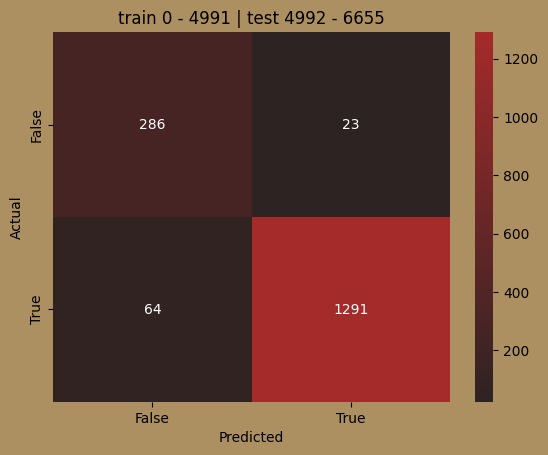

Optimization terminated successfully.
         Current function value: 0.263542
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 5954
Model:                          Logit   Df Residuals:                     5950
Method:                           MLE   Df Model:                            3
Date:                Fri, 10 Nov 2023   Pseudo R-squ.:                  0.4349
Time:                        16:36:14   Log-Likelihood:                -1569.1
converged:                       True   LL-Null:                       -2776.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.8860      0.209    -37.780      0.000      -8.295      -7.477
ipc_lag_1      2.8618      0.

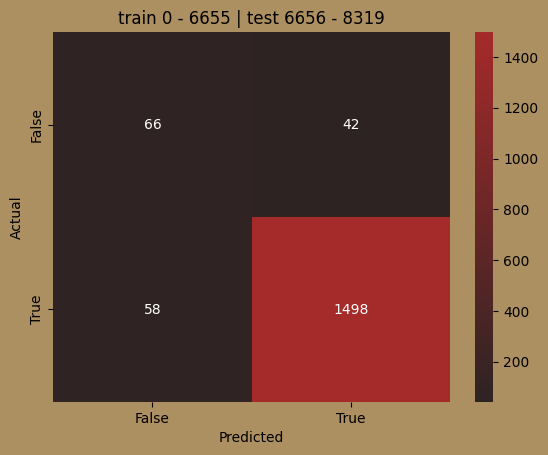

Optimization terminated successfully.
         Current function value: 0.297659
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 7618
Model:                          Logit   Df Residuals:                     7614
Method:                           MLE   Df Model:                            3
Date:                Fri, 10 Nov 2023   Pseudo R-squ.:                  0.5120
Time:                        16:36:14   Log-Likelihood:                -2267.6
converged:                       True   LL-Null:                       -4646.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.2706      0.182    -45.491      0.000      -8.627      -7.914
ipc_lag_1      2.6647      0.

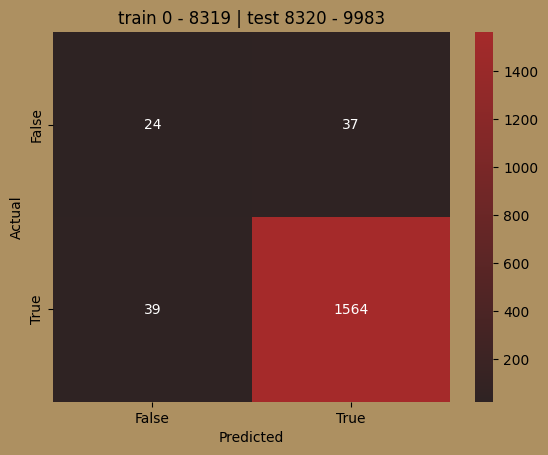

Mean Acc: 0.95


<Figure size 640x480 with 0 Axes>

In [76]:
X = df[['hunger', 'refugees',
       'conflict', 'politics',
       'production', 'land', 'pests',
       'environment','count_violence_lag_3', 'ndvi_anom_lag_3',
       'food_price_idx_lag_3', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3']]

X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits
acc_values = list() # Initinalize empty lists to score accuracy scores

for train_index, val_index in cv.split(X): # Loop over the different training-test splits
    
    y_binary = y > 2 # Convert y to binary variable
    y_binary[y.isna()] = pd.NA # Conserve NaN values
    y_binary = y_binary.astype("float32") # Convert y to float

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)
    
    cols = ['const', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'] # Select columns to use in model
    model = sm.Logit(y_train, X_train[cols], missing="drop") # Initialize Logit model
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test[cols]) # Run model on test data

    # Convert prediction and validation to boolean
    y_pred = y_pred.round().astype(bool)
    y_val = y_val.round().astype(bool)

    # Drop all rows from prediction and validation where validation is null
    y_pred = y_pred[list(y_val.isnull()['ipc']==False)]
    y_val.dropna(inplace=True)

    acc_values.append(accuracy_score(y_val, y_pred)) # Append accuracy to list

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'], binary = True) # Plot confusion matrix
    
print(f"Mean Acc: {np.mean(acc_values):.2f}") # Print Acc

# VIF AND Perfromance Metrics of OLS

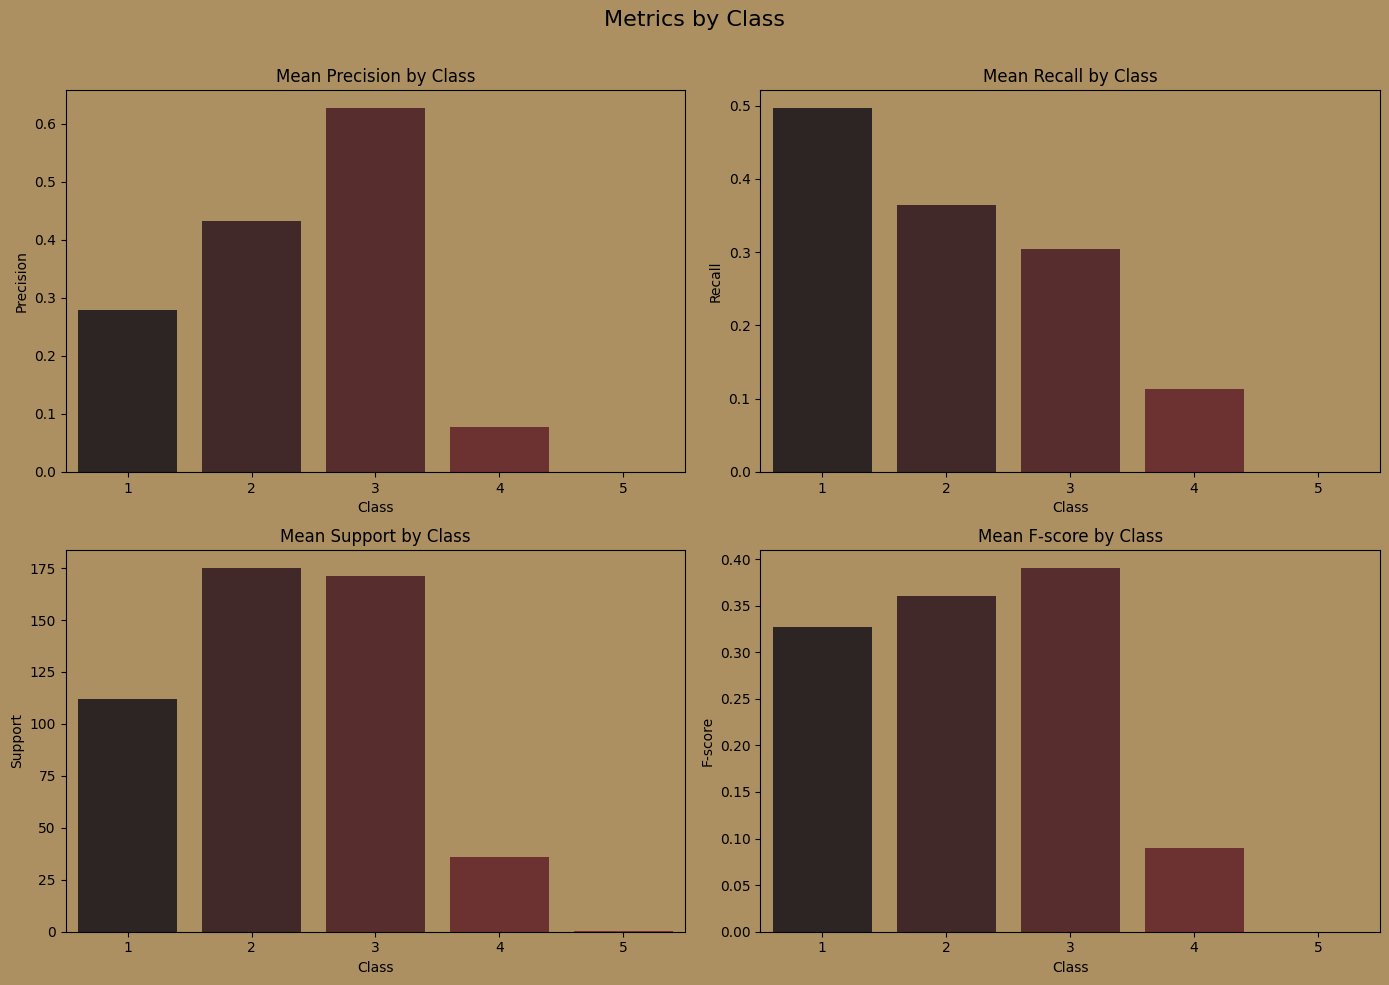

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data
classes = [1, 2, 3, 4, 5]
precision = [0.27929790904650975, 0.4315277436470792, 0.6268270980339946, 0.07789115646258504, 0.0]
recall = [0.49644007155635067, 0.36488646137443775, 0.3048203347121679, 0.11338548457192524, 0.0]
support = [111.8, 175.0, 171.0, 36.0, 0.2]
f_score = [0.327625329442347, 0.3600777118851029, 0.3903679105274499, 0.08989371980676329, 0.0]

brown_palette = sns.dark_palette("brown")

# Set up the matplotlib figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Metrics by Class', fontsize=16)

# Precision plot
sns.barplot(x=classes, y=precision, ax=axes[0, 0], palette=brown_palette)
axes[0, 0].set_title('Mean Precision by Class')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].set_xlabel('Class')

# Recall plot
sns.barplot(x=classes, y=recall, ax=axes[0, 1], palette=brown_palette)
axes[0, 1].set_title('Mean Recall by Class')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].set_xlabel('Class')

# Support plot
sns.barplot(x=classes, y=support, ax=axes[1, 0], palette=brown_palette)
axes[1, 0].set_title('Mean Support by Class')
axes[1, 0].set_ylabel('Support')
axes[1, 0].set_xlabel('Class')

# F-score plot
sns.barplot(x=classes, y=f_score, ax=axes[1, 1], palette=brown_palette)
axes[1, 1].set_title('Mean F-score by Class')
axes[1, 1].set_ylabel('F-score')
axes[1, 1].set_xlabel('Class')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()


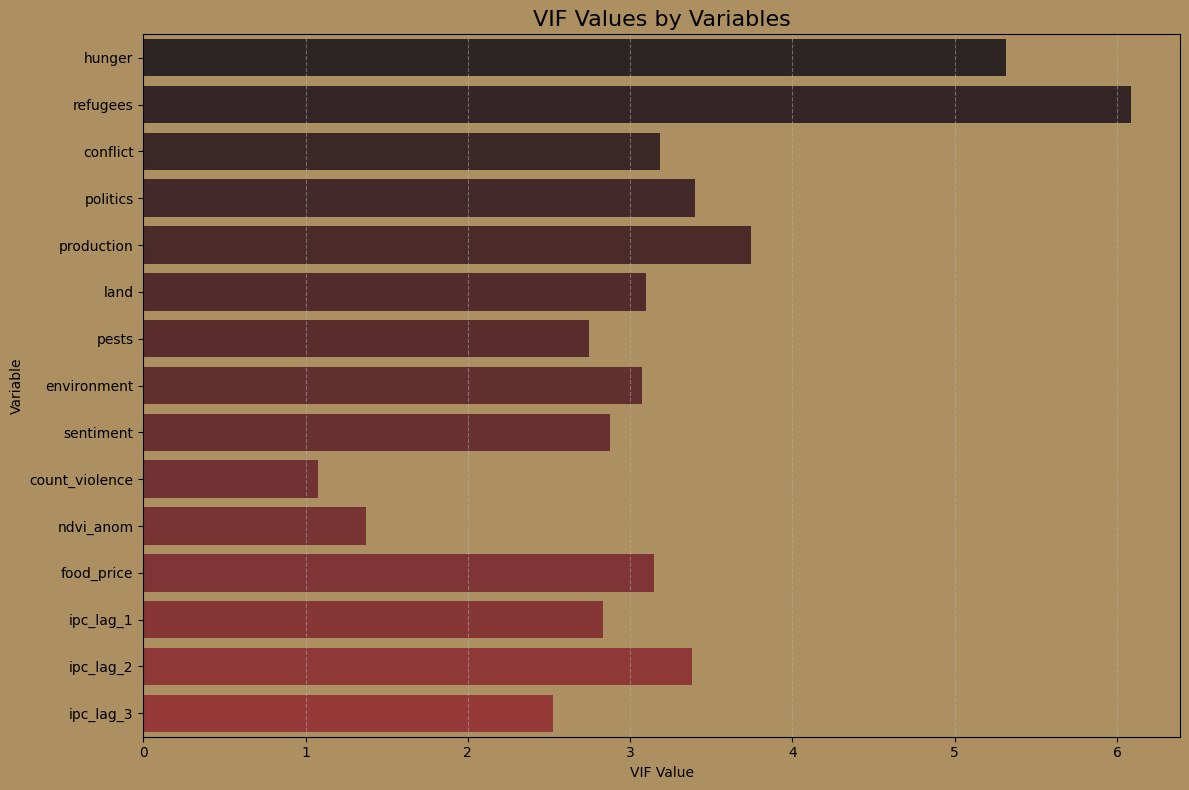

In [78]:
brown_palette = sns.dark_palette("brown", 15)

# VIF Data
variables = [
    "hunger", "refugees", "conflict", "politics",
    "production", "land", "pests", "environment", "sentiment",
    "count_violence", "ndvi_anom", "food_price", "ipc_lag_1", "ipc_lag_2", "ipc_lag_3"
]
vif_values = [
    5.3135835534299325, 6.083677140147307, 3.18133189776064, 3.4004150830717976,
    3.7461198760655003, 3.098621112606724, 2.7457583659251004, 3.0755646577355638, 2.8758970241230335,
    1.0769910102311533, 1.3752090962110155, 3.1481658741250294, 2.834938537228281, 3.3835805670478094, 2.5246701233271267
]

# Visualization
plt.figure(figsize=(12, 8))
sns.barplot(y=variables, x=vif_values, palette=brown_palette, orient="h")
plt.title("VIF Values by Variables", fontsize=16)
plt.xlabel("VIF Value")
plt.ylabel("Variable")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
